In [1]:
cd ../TileEM/

In [2]:
%pylab inline
from TileEM_plot_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_DIR="output"
os.chdir(DATA_DIR)

# Problem: The tiles are not exactly non-overalpping 

## Debugging BB2TileExact 

In [5]:
def overlap(a,b):
    if a.area>b.area:
        larger_area = a.area
    else:
        larger_area = b.area
    return a.intersection(b).area/larger_area

In [244]:
def compute_unique_tileset(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    if vt.area<t.area:
                        verified_tiles.remove(vt)
                        verified_tiles.append(t)
                    break
            except(shapely.geos.TopologicalError):
                #Do not add in the tile that is causing problematic topological error
                duplicated=True
                print "Topological Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    return verified_tiles

In [245]:
DATA_DIR="outputsample"

In [246]:
def slow_cascaded_union(tiles):
    all_tiles  = copy.deepcopy(tiles)
    Utile=tiles[0]
    all_tiles.remove(tiles[0])
    i=1
    loss_tiles = []
    while(len(all_tiles)>0):
        tile = tiles[i]
        try:
            Utile = Utile.union(tile)
        except(shapely.geos.TopologicalError):
            try:
                Utile =Utile.buffer(0).union(tile.buffer(0))
            except(shapely.geos.TopologicalError):
#                 return tile,Utile 
                #print "Throwing away:", tile.area 
                loss_tiles.append(tile)
        all_tiles.remove(tile)
        i+=1
    try:
        Utile=Utile.union(cascaded_union(loss_tiles))
    except(shapely.geos.TopologicalError):
        try:
            Utile=Utile.buffer(9e-13).union(cascaded_union(loss_tiles).buffer(0))
        except(shapely.geos.TopologicalError):
            loss_area = sum([t.area for t in loss_tiles])
            print "Throwing away:", loss_area
    return loss_tiles,Utile

In [247]:
def visualizeTilesSeparate(tiles,colorful=True):
    plt.figure()
    colors=cm.rainbow(np.linspace(0,1,len(tiles)))
    for t,i in zip(tiles,range(len(tiles))): 
#         plt.figure()
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True,fill_color=c)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True,fill_color=c)

In [248]:
def compute_verfied_tiles_duplication_rate(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    print "Duplication rate: ", duplicate_count/float(len(tiles))
    return verified_tiles

In [249]:
# verified_tiles = compute_verfied_tiles_duplication_rate(tiles)

In [250]:
def visualizeTiles(tiles,colorful=True):
    plt.figure()
    colormap = plt.cm.Paired
    colors = [colormap(i) for i in np.linspace(0, 1,len(tiles))]
    for t,i in zip(tiles,range(len(tiles))): 
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True)

In [251]:
def BB2TileExact(objid,BB,tqdm_on=False,save_tiles=True):
    tiles=[]
    if tqdm_on: 
        BB_lst = tqdm(range(len(BB)))
    else:
        BB_lst=range(len(BB))
    all_tiles=[]
    for i in BB_lst:
        bi = BB[i]
        # base case, when i=0, only 2 polygon intersecting
        if i==0:
            tiles.append(bi)
        else: 
            xj_lst = []
            tiles_tmp =copy.deepcopy(tiles)
            for tj in tiles:

                try:
                    xj=tj.intersection(bi)
                    if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                        diff_region = tj.difference(xj)
                        if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                            tiles_tmp.remove(tj)
                            #print "Adding intersection starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,xj)
                            #print "Adding diff_region starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,diff_region)
                            if xj.intersection(diff_region).area>1e-8:
                                print "break #1"
                                break
                            if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                                print "break#2"
                                print xj.union(diff_region).area
                                print tj.area
                                print xj.union(diff_region).area==tj.area
                                break
                            xj_lst.append(xj)
                        else:
                            xj_lst.append(tj)
                except(shapely.errors.TopologicalError):
                    print "xj list last item ignored"
                    xj_lst=xj_lst[:-1]
                    pass
    #             try:
    #                 Uorig_tiles = cascaded_union(tiles)
    #                 loss_area=0
    #             except(ValueError):
    #                 print "Used slow cascade union instead"
    #                 loss_tiles,Uorig_tiles=slow_cascaded_union(tiles)
    #                 loss_area = sum([t.area for t in loss_tiles])

            #try:
            print "Bi-(Bi intersect Uorig_tiles)"
            #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
            #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
            leftovers = bi
            for t,tidx in zip(tiles_tmp,range(len(tiles_tmp))): #tiles cause topolgical error
#                 print tidx
                try:

                    leftovers = leftovers.difference(t)
                    if  type(leftovers)==shapely.geometry.MultiPolygon:
                        for i,l in enumerate(leftovers):
                            if l.area<1e-8:
                                leftovers =leftovers.difference(l)
                except(shapely.geos.TopologicalError):
                    print "Topological error #67"
                    return leftovers,t

    #             except(shapely.errors.TopologicalError): 
    #                 print "diff toplogical error"
    #                 leftovers = bi.difference(bi.intersection(Uorig_tiles.buffer(1e-10)))
    #             except(ValueError):
    #                 print "ValueError"
    #                 leftovers=[]
            tiles =copy.deepcopy(tiles_tmp)
            try:
                print "leftover second step"
                leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
                if leftovers.intersection(cascaded_union(xj_lst)).area>1e-6:
                    print "pass through break #3"
                    print leftovers.intersection(cascaded_union(xj_lst)).area
    #                     break
                if not np.isclose(leftovers.union(cascaded_union(xj_lst)).area,bi.area,rtol=1e-8):
                    print "pass through break #4"
                    print leftovers.union(cascaded_union(xj_lst)).area - bi.area
    #             except(shapely.errors.TopologicalError):
    #                 leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
            except(shapely.errors.TopologicalError):
                print "do slow cascade union instead"
                loss_tiles,Utile = slow_cascaded_union(xj_lst)
                leftovers = leftovers.difference(leftovers.intersection(cascaded_union(loss_tiles))).difference(Utile)
        #             break
            print "Adding leftovers starting: ",len(tiles)
            vtiles = compute_verfied_tiles_duplication_rate(tiles)
            add_object_to_tiles(tiles,leftovers)
            print "Finished leftovers starting: ",len(tiles)
        all_tiles.append(tiles)
        uniquify_tiles = compute_unique_tileset(tiles)
        boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
        if not boolean_uniquify_tiles:
            print "BAD: BB",i
            #tiles = uniquify_tiles
    #             return tiles
            break 

    if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

In [ ]:
objid=10
sampleNworkers=30
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
###################################
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    print "------------------------------Adding BB"+str(i)+"------------------------------"
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:

            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        xj_lst.append(xj)
                    else:
                        xj_lst.append(tj)
            except(shapely.errors.TopologicalError):
                print "xj list last item ignored"
                xj_lst=xj_lst[:-1]
                pass

        uniquify_tiles = compute_unique_tileset(tiles)
        boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
        if not boolean_uniquify_tiles:
            print "before leftover BAD: BB,continue",i
            tiles = uniquify_tiles
            #break 
        else:
            print "----------- All tiles before leftover calculation is non-overlapping ---------------"
                  

        print "Bi-(Bi intersect Uorig_tiles)"
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
        leftovers = bi
        for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
            try:

                leftovers = leftovers.difference(t) 

            except(shapely.geos.TopologicalError):
                print "Topological error #67"

        tiles =copy.deepcopy(tiles_tmp)

        print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    #uniqufy check !!
    uniquify_tiles = compute_unique_tileset(tiles)
    boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    if not boolean_uniquify_tiles:
        print "BAD: BB, continuing but remove duplicates",i
        tiles = uniquify_tiles
        #return tiles
        # break 

if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  4
Finished leftovers starting:  7
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  29

 10%|█         | 3/30 [00:00<00:03,  8.54it/s]


Finished leftovers starting:  39
------------------------------Adding BB3------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 67
Finished leftovers starting:  70
------------------------------Adding BB4------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.052 248.345, 536.739 253.071) and LINESTRING (535.052 248.345, 538.045 256.727) at 535.24490154631417 248.8857243296795



Bi-(Bi intersect Uorig_tiles)
Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (519.692 334.692, 530.182 334.273) and LINESTRING (530.182 334.273, 525.676 334.453) at 529.39189382046516 334.3043242471814
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 246, 527.207 242.276) and LINESTRING (538.045 256.727, 527.207 242.276) at 527.2068965517243 242.27586206896567



Topological error #67
Topological error #67
Adding leftovers starting: 

 76%|███████▋  | 87/114 [00:01<00:00, 86.97it/s] 

 105
Finished leftovers starting:  114
Duplicate tiles: 

 106 55 1.0
Duplicate tiles:  107 38 1.0
BAD: BB, continuing but remove duplicates

 4
------------------------------Adding BB5------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (386.815 260.579, 386.815 260.579) and LINESTRING (385.538 257.038, 386.815 260.579) at 386.81523500810374 260.578606158833



Bi-(Bi intersect Uorig_tiles)
Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (551.025 323.417, 550.168 323.825) and LINESTRING (553.176 322.392, 550.168 323.825) at 550.17615363712571 323.82087922041637



Topological error #67
Adding leftovers starting: 

 20%|██        | 6/30 [00:11<00:45,  0.53it/s]

 176
Finished leftovers starting:  176
------------------------------Adding BB6------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 282, 535.844 274.281) and LINESTRING (535.84 274.288, 535.844 274.281) at 535.84374999999989 274.28125000000028



Bi-(Bi intersect Uorig_tiles)
Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.061 296.515, 563.548 304.355) and LINESTRING (562 309, 563.548 304.355) at 563.54838709677415 304.35483870967744



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.14 278.907) and LINESTRING (534.776 276.204, 534.14 278.907) at 534.52119820558312 277.28490762627132



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.14 278.907, 534.14 278.907) and LINESTRING (534.14 278.907, 534.14 278.907) at 534.13953488372101 278.90697674418578



Topological error #67

 95%|█████████▍| 224/236 [00:06<00:00, 34.76it/s]


Adding leftovers starting:  229
Finished leftovers starting:  236
Duplicate tiles:  229 225 0.999999999999
Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685
BAD: BB, continuing but remove duplicates

 6
------------------------------Adding BB7------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.455 297, 559.4 291.4) and LINESTRING (560.017 292.53, 559.4 291.4) at 559.54372182793361 291.66349001787842



Bi-(Bi intersect Uorig_tiles)
Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (559 290.667, 553 286) and LINESTRING (559 290.667, 557 287) at 559 290.66666666666657
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (565 306, 564.032 301.806) and LINESTRING (564.032 301.806, 564.135 302.784) at 564.0322580645161 301.80645161290323
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (540.66 258.617, 535.348 249.174) and LINESTRING (535.348 249.174, 537.765 255.941) at 535.3478260869565 249.17391304347831



Topological error #67
Topological error #67
Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151



Topological error #67

In [252]:
objid=12
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
# tiles = BB2TileExact(12,BB,tqdm_on=True,save_tiles=True)
##########################################
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    print "------------------------------Adding BB"+str(i)+"------------------------------"
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:

            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        xj_lst.append(xj)
                    else:
                        xj_lst.append(tj)
            except(shapely.errors.TopologicalError):
                print "xj list last item ignored"
                xj_lst=xj_lst[:-1]
                pass
#             try:
#                 Uorig_tiles = cascaded_union(tiles)
#                 loss_area=0
#             except(ValueError):
#                 print "Used slow cascade union instead"
#                 loss_tiles,Uorig_tiles=slow_cascaded_union(tiles)
#                 loss_area = sum([t.area for t in loss_tiles])
        # Uniqufy check !!
        uniquify_tiles = compute_unique_tileset(tiles)
        boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
        if not boolean_uniquify_tiles:
            print "before leftover BAD: BB,continue",i
            tiles = uniquify_tiles
            #break 
        else:
            print "----------- All tiles before leftover calculation is non-overlapping ---------------"
                  

        print "Bi-(Bi intersect Uorig_tiles)"
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
        leftovers = bi
        for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
            try:
#                 if leftovers.intersects(t):                  
#                     if i==5:
#                         try:
#                             plt.figure()
#                             plt.title(tidx)
#                             if  type(leftovers)==shapely.geometry.MultiPolygon:
#                                 visualizeTilesSeparate(leftovers)
#                             else:
#                                 plot_coords(leftovers)
#                             plot_coords(t,color="#32cd32")
#                         except(AttributeError):
#                             print "Can not plot Geometry collection for tile",tidx 
                leftovers = leftovers.difference(t) 
                #print "leftover intersection area",leftovers.intersection(t).area
                #try:
                #    print "check:", np.isclose(leftovers.intersection(t).area,0,rtol=1e-8)#leftovers.intersects(t)
                #except:#(PredicateError):
                #    print "PredicateError"

#                 if  type(leftovers)==shapely.geometry.MultiPolygon:
#                     for i,l in enumerate(leftovers):
#                         if l.area<1e-8:
#                             leftovers =leftovers.difference(l)
            except(shapely.geos.TopologicalError):
                print "Topological error #67"
#         for xj in xj_lst:
#             try:
#                 leftovers=leftovers.difference(xj)
#             except(shapely.errors.TopologicalError):
#                 print "diff toplogical error"


#                 leftovers = bi.difference(bi.intersection(Uorig_tiles.buffer(1e-10)))
#             except(ValueError):
#                 print "ValueError"
#                 leftovers=[]
        tiles =copy.deepcopy(tiles_tmp)
#         try:
#             print "leftover second step"
#             leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
#             if leftovers.intersection(cascaded_union(xj_lst)).area>1e-6:
#                 print "pass through break #3"
#                 print leftovers.intersection(cascaded_union(xj_lst)).area
# #                     break
#             if not np.isclose(leftovers.union(cascaded_union(xj_lst)).area,bi.area,rtol=1e-8):
#                 print "pass through break #4"
#                 print leftovers.union(cascaded_union(xj_lst)).area - bi.area
# #             except(shapely.errors.TopologicalError):
# #                 leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
#         except(shapely.errors.TopologicalError):
#             print "do slow cascade union instead"
#             loss_tiles,Utile = slow_cascaded_union(xj_lst)
#             leftovers = leftovers.difference(leftovers.intersection(cascaded_union(loss_tiles))).difference(Utile)
#     #             break
        print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    #uniqufy check !!
    uniquify_tiles = compute_unique_tileset(tiles)
    boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    if not boolean_uniquify_tiles:
        print "BAD: BB, continuing but remove duplicates",i
        tiles = uniquify_tiles
        #return tiles
        # break 

if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  3
Finished leftovers starting:  6
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 30%|███       | 3/10 [00:00<00:00, 23.96it/s]

 13
Finished leftovers starting:  17
------------------------------Adding BB3------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 31
Finished leftovers starting:  39
------------------------------Adding BB4------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 60
Finished leftovers starting:  60
------------------------------Adding BB5------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (386 438, 385.538 437.692) and LINESTRING (385.538 437.692, 390.632 439.789) at 385.53846153846212 437.69230769230813



Bi-(Bi intersect Uorig_tiles)
Topological error #67
Adding leftovers starting: 

 60%|██████    | 6/10 [00:03<00:02,  1.55it/s]

 94
Finished leftovers starting:  94
------------------------------Adding BB6------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 305 303



Bi-(Bi intersect Uorig_tiles)
Topological error #67
Adding leftovers starting: 

 94%|█████████▍| 112/119 [00:01<00:00, 68.48it/s]

 113
Finished leftovers starting:  119
Duplicate tiles: 

 117 51 0.999999999998
BAD: BB, continuing but remove duplicates 6
------------------------------Adding BB7------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 164
Finished leftovers starting:  164
------------------------------Adding BB8------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Bi-(Bi intersect Uorig_tiles)
Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (366.291 380.797, 367.333 382.333) and LINESTRING (366.184 380.653, 367.333 382.333) at 367.33333333332894 382.33333333332689



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (395.571 440.857, 395.25 441.5) and LINESTRING (395.571 440.857, 396.5 439) at 395.57142857142861 440.85714285714283



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (399 429, 399 436.667) and LINESTRING (398.625 437.125, 399.488 436.07) at 399 436.66666666666669



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (395.863 440.273, 395.25 441.5) and LINESTRING (395.571 440.857, 397.091 439) at 395.57142857142873 440.85714285714266



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 315.25 304.25



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.977 290.573, 305.379 305.517) and LINESTRING (303.143 288.143, 305.962 290.962) at 305.96153846153845 290.96153846153845



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 305.14331638757005 311.41709031074907



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.718 409.59, 366.291 380.797) and LINESTRING (366.291 380.797, 366.291 380.797) at 366.29113924050637 380.79746835443046



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (345.061 348.576, 344.742 348.063) and LINESTRING (345.061 348.576, 344.736 348.054) at 344.95268637002516 348.40214763873621



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (322.923 343.258, 318.305 336.962) and LINESTRING (311.277 327.377, 319.523 338.623) at 319.15453657369886 338.11982260049854



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (353 394, 349.33 388.17) and LINESTRING (349.33 388.17, 349.33 388.17) at 349.32954545454567 388.17045454545496



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (376.556 431.407, 373.145 425.582) and LINESTRING (376.556 431.407, 373.145 425.582) at 373.63832070707127 426.42379787458009



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (376.556 431.407, 373.145 425.582) and LINESTRING (373.145 425.582, 377.231 432.154) at 373.14545454545527 425.58181818181941



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (322.923 343.258, 318.305 336.962) and LINESTRING (318.305 336.962, 330.579 357.22) at 318.30534351145053 336.961832061069



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (339.364 341.455, 340.284 342.605) and LINESTRING (340.6 343, 339.364 341.455) at 339.82333473172019 342.02916841465026



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 318.11562500000008 307.62272727272739



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306 290, 305.895 292.613) and LINESTRING (305.962 290.962, 303.143 288.143) at 305.96153846153845 290.96153846153845



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (378.097 435.654, 388 452) and LINESTRING (378 436, 378.384 436.128) at 378.38414634146335 436.1280487804878



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (393 444, 388.81 441.524) and LINESTRING (390.772 441.675, 388.81 441.524) at 388.80952380952391 441.52380952380952



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 397.18214352659749 439.19438689437465



Topological error #67

 90%|█████████ | 9/10 [00:33<00:03,  0.27it/s]


Adding leftovers starting:  199
Finished leftovers starting:  199
------------------------------Adding BB9------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (398.5 437.5, 398.5 437.5) and LINESTRING (398.5 437.5, 396.881 439.581) at 398.50000000000006 437.49999999999994



Bi-(Bi intersect Uorig_tiles)
Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.538 437.692, 380.164 435.479) and LINESTRING (377.231 432.154, 385.538 437.692) at 385.53846153846143 437.69230769230757



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (369.379 422.552, 367.103 419) and LINESTRING (369.379 422.552, 366.821 418.429) at 369.37931034482654 422.55172413792945



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (395.538 441.308, 395 442) and LINESTRING (395.538 441.308, 395.243 441.688) at 395.41267949591588 441.46941207667953



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (353 394, 354.874 397.323) and LINESTRING (349.33 388.17, 354.874 397.323) at 354.87443946188313 397.32286995515648



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (374.358 430.318, 377.61 433.209) and LINESTRING (375.455 431.293, 371.19 424.253) at 375.45518453427064 431.29349736379612



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (375.753 433.414, 377.233 434.228) and LINESTRING (376.663 433.915, 377.109 434.61) at 376.66336633663366 433.91485148514852



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (377.231 432.154, 385.538 437.692) and LINESTRING (385.538 437.692, 385.538 437.692) at 385.53846153846155 437.69230769230768



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.289 312.044, 306.289 312.044) and LINESTRING (306.289 312.044, 306.289 312.044) at 306.28888888888895 312.04444444444511



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (353 394, 354.874 397.323) and LINESTRING (349.33 388.17, 354.874 397.323) at 354.87443946188279 397.32286995515591



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (366.821 418.429, 371.19 424.253) and LINESTRING (371.19 424.253, 371.19 424.253) at 371.18987341772146 424.25316455696196



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (324.2 345, 318.305 336.962) and LINESTRING (322 342, 322 342) at 322 342



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.895 292.632, 306.869 294.058) and LINESTRING (306.777 296.9, 306.927 292.271) at 306.86908690869086 294.05830583058304



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (375.753 433.414, 376.851 434.018) and LINESTRING (377.233 434.228, 376.663 433.915) at 376.67397163713605 433.92068440042482



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (379.129 435.803, 377.109 434.61) and LINESTRING (377.663 434.937, 378.359 435.348) at 377.84941214585183 435.04737990436695



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (379.487 437.949, 378.384 436.128) and LINESTRING (379.545 436.515, 378 436) at 378.38414634146341 436.1280487804878



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306 321, 318 339) and LINESTRING (317.091 337.409, 315.5 335.25) at 315.50000000000057 335.2500000000008



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (396.609 439.932, 398.5 437.5) and LINESTRING (398.5 437.5, 395.243 441.688) at 397.09294593512618 439.30906951198062



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (401.668 432.521, 402 432) and LINESTRING (401.67 432.518, 399.524 429.381) at 401.67028985507244 432.518115942029



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (398.5 437.5, 395.243 441.688) and LINESTRING (395.253 441.674, 395 442) at 395.24257425742576 441.68811881188117



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.222 304.889, 305 303) and LINESTRING (305.222 304.889, 306 308) at 305.22222222222223 304.88888888888897



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 333.15503875968989 333.06976744186039



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (366.235 417.647, 366.235 417.647) and LINESTRING (366.235 417.647, 366.235 417.647) at 366.2352941176473 417.64705882352973



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (368 424, 369.474 425.789) and LINESTRING (369.474 425.789, 335.571 369.286) at 369.47368421052619 425.78947368421029



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (308.928 323.325, 308.928 323.325) and LINESTRING (309.553 324.404, 308.928 323.325) at 308.92771084337363 323.32530120481948



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.575 438.954, 398.5 437.5) and LINESTRING (398.5 437.5, 398.5 437.5) at 398.50000000000006 437.49999999999994



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.575 438.954, 398.5 437.5) and LINESTRING (398.5 437.5, 398.5 437.5) at 398.50000000000006 437.49999999999994



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (396.226 440.424, 395 442) and LINESTRING (395.243 441.688, 396.252 440.39) at 395.71282766273578 441.0835072907683



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.531 439.022, 398.5 437.5) and LINESTRING (398.1 439, 397.545 439) at 397.54545454545456 439



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 337 341



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (399 431.618, 399 436.667) and LINESTRING (398.891 436.8, 399.136 436.5) at 399 436.66666666666669



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (399 436.714, 399.136 436.5) and LINESTRING (399 436.667, 399.136 436.5) at 399.13636363636351 436.50000000000017



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (310.323 296.067, 309.667 295.333) and LINESTRING (309.667 295.333, 312.333 299.212) at 309.66666666666663 295.33333333333331



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (323.8 315.891, 329.358 325.239) and LINESTRING (329.358 325.239, 328.788 324.064) at 329.35820895522374 325.23880597014903



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (328.788 324.064, 329.358 325.239) and LINESTRING (329.358 325.239, 323.8 315.891) at 329.35820895522374 325.23880597014903



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (327.28 320.953, 324.389 314.99) and LINESTRING (323.8 315.891, 327.28 320.953) at 327.28037383177565 320.95327102803731



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (311.647 327.882, 316.205 334.098) and LINESTRING (318.617 337.387, 311.647 327.882) at 316.05364132445391 333.89132907880077



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.358 306.045, 305.358 306.045) and LINESTRING (305.358 306.045, 305.222 304.889) at 305.35820895522386 306.04477611940285



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (329.358 325.239, 321 308) and LINESTRING (323.8 315.891, 329.358 325.239) at 329.35820895522374 325.23880597014897



Topological error #67

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (315.36 301.697, 310.86 296.667) and LINESTRING (310.86 296.667, 315.36 301.697) at 314.89607133948607 301.17796208530802



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67

ERROR:shapely.geos:TopologyException: side location conflict at 353 394



Topological error #67


Adding leftovers starting:  248
Finished leftovers starting:  248


In [271]:

def createObjIndicatorMatrix(objid,tiles="",load_existing_tiles_from_file=False, PLOT=False,sampleNworkers=-1,random_state=111,PRINT=False,SAVE=False,EXCLUDE_BBG=True,overlap_threshold=0.8,tile_only=False,tqdm_on=False):

    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects = bb_info[bb_info["object_id"]==objid]
    if EXCLUDE_BBG: bb_objects =  bb_objects[bb_objects.worker_id!=3]
    # Sampling Data from Ji table 
    if sampleNworkers>0 and sampleNworkers<len(bb_objects):
        bb_objects = bb_objects.sample(n=sampleNworkers,random_state=random_state)
    # Create a list of polygons based on worker BBs 
    xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    BB = []
    for xyloc in xylocs:
        BB.append(Polygon(xyloc).buffer(0))

    #Compute Tiles 
    if load_existing_tiles_from_file:
        tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
        #worker_lst= pkl.load(open("{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    elif tiles=="":
        tiles = BB2TileExact(objid,BB,tqdm_on=tqdm_on,save_tiles=SAVE)
    if tile_only:
    	if PLOT: visualizeTiles(tiles)
    	return tiles,0
    # Convert set of tiles to indicator matrix for all workers and tiles
    # by checking if the worker's BB contains the tile pieces
    # The indicator matrix is a (N + 1) X M matrix, 
    # with first N rows indicator vectors for each annotator and
    # the last row being region sizes
    worker_lst = list(bb_objects.worker_id)
    M = len(tiles)
    N = len(worker_lst)
    if PRINT: 
        print "Number of non-overlapping tile regions (M) : ",M
        print "Number of workers (N) : ",N
    indicator_matrix = np.zeros((N+1,M))

    for  wi in range(N):
        worker_id = worker_lst[wi]
        worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
        worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]]))).buffer(0)

        # Check if worker's polygon contains this tile
        for tile_i in range(M):
            tile = tiles[tile_i]
            if worker_BB_polygon.contains(tile.centroid):
                indicator_matrix[wi][tile_i]=1
            else:
            	try:
            		tileBB_overlap = tile.intersection(worker_BB_polygon).area/float(tile.area)
            		if tileBB_overlap>=overlap_threshold:
            			indicator_matrix[wi][tile_i]=1
            	except(shapely.errors.TopologicalError):
            		pass

    # The last row of the indicator matrix is the tile area
    for tile_i in range(M):
        tile=tiles[tile_i]
        indicator_matrix[-1][tile_i]=tile.area
    # Debug plotting all tiles that have not been voted by workers 
    all_unvoted_tiles=np.where(np.sum(indicator_matrix[:-1],axis=0)==0)[0]
    if PRINT:
        print "all unvoted tiles:",all_unvoted_tiles
        print "all unvoted workers:",np.where(np.sum(indicator_matrix,axis=1)==0)[0]
    if PLOT or PRINT:
        print "Object ",objid
        sanity_check(indicator_matrix,PLOT)
    if SAVE:
    	pkl.dump(worker_lst,open('../{0}/worker{1}.pkl'.format(DATA_DIR,objid),'w'))
    	pkl.dump(indicator_matrix,open('../{0}/indMat{1}.pkl'.format(DATA_DIR,objid),'w'))
    return worker_lst,tiles,indicator_matrix

In [257]:
unique_tiles = compute_unique_tileset(tiles)

In [274]:
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=unique_tiles,sampleNworkers=10)

In [278]:
# sanity_check(indicator_matrix,PLOT=True)

Best worker's PR against BBG:  0.973312843473 0.977701312091
192

ERROR:shapely.geos:TopologyException: side location conflict at 299.65753424657532 286.41095890410958
ERROR:shapely.geos:TopologyException: EdgeRing::computePoints: found null Directed Edge
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.538 437.692, 377.231 432.154) and LINESTRING (377.231 432.154, 385.538 437.692) at 383.46153846153845 436.30769230769226
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.371 309.486, 306.371 309.486) and LINESTRING (306.371 309.486, 306.371 309.486) at 306.37142857142868 309.48571428571483
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.777 296.9, 339.354 344.487) and LINESTRING (306.777 296.9, 339.354 344.488) at 339.35344297335422 344.48689218656648
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.787 295.326, 306.782 296.773) and LINESTRING (306.777 296.9, 306.869 294.058) at 306.78


1.02358234421 0.950162450091


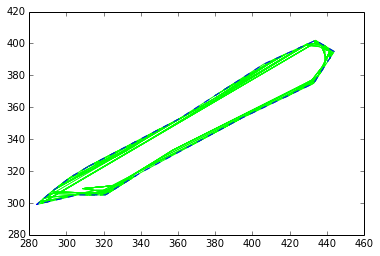

In [294]:
p,r=PR_compare(objid,unique_tiles,sampleNworkers=5)

In [284]:
def join_tiles(solutionList,tiles): 
    '''
    Given a solutionList of tile indicies, join the tiles together into a Polygon/MultiPolygon object.
    '''
    try:
        return cascaded_union([tiles[tidx] for tidx in solutionList]),[]
    except:
        #slow version, run through and exclude problematic solutionset item
        Utile=tiles[0]
        problematic_tiles =[]
        for soln in solutionList:
            try:
                Utile=Utile.union(tiles[soln])
            except(shapely.geos.TopologicalError):
                problematic_tiles.append(tiles[soln])
        problematic_tiles.append(Utile)
        return Utile,problematic_tiles

In [293]:
def PR_compare(objid,tiles,sampleNworkers=40):    
    os.chdir("..")
    # worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,PRINT=True,sampleNworkers=sampleNworkers,tqdm_on=False,tile_only=False)
    #worker_lst = pkl.load(open("{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    #tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    #objIndicatorMat = pkl.load(open("{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
    worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
    os.chdir(DATA_DIR)
    
    worker_precision_lst,worker_recall_lst = compute_worker_lst_PR_obj(objid,worker_lst)
    best_worker =  np.argmax(worker_recall_lst)
    print "Best worker's PR against BBG: ", max(worker_precision_lst),max(worker_recall_lst)

    approved_tiles = np.where(indicatorMat[best_worker]==1)[0]
    for tidx in approved_tiles:
        plot_coords(tiles[tidx],color="lime")

    bb_objects = bb_info[bb_info["object_id"]==objid]
    bb_objects =  bb_objects[bb_objects.worker_id!=3]
    best_worker_id = worker_lst[best_worker]
    print best_worker_id
    worker_bb_info = bb_objects[bb_objects["worker_id"]==best_worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))#.buffer(0)

    plot_coords(worker_BB_polygon,linestyle='--',color='#0000ff')
    
    joined_bb,problematic_tiles = join_tiles(approved_tiles,tiles)
    if problematic_tiles==[]:
        intersect_area = worker_BB_polygon.intersection(joined_bb).area
    else:
        intersect_area =0# worker_BB_polygon.intersection(joined_bb).area
#         for problematic_tile in problematic_tiles:
        for tidx in approved_tiles:
            intersect_area +=worker_BB_polygon.intersection(tiles[tidx]).area
    precision = intersect_area/joined_bb.area
    recall = intersect_area/worker_BB_polygon.area
    print precision,recall
    if precision>1:
        precision=1
    if recall>1:
        recall=1
    return precision,recall

In [111]:
# leftovers = bi
# for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
#     leftovers = leftovers.difference(t)   
#     print leftovers

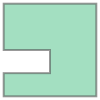

In [196]:
Polygon([[0,0],[4,0],[4,4],[0,4]]).symmetric_difference(Polygon([[0,1],[2,1],[2,2],[0,2]]))

In [205]:
poly1 = Polygon([[0,0],[4,0],[4,4],[0,4]])
poly2 = Polygon([[0,1],[2,1],[2,2],[1,2]])
poly3 = poly1.difference(poly2)

True
True


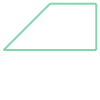

In [212]:
print poly3.intersects(poly2)
print np.isclose(poly3.intersection(poly2).area,0,rtol=1e-8)
poly3.intersection(poly2)

True
14.5


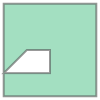

In [211]:
print poly3.intersects(poly1)
print poly3.intersection(poly1).area
poly3.intersection(poly1)

Intersect before: True
2864.80421431
Intersect after: True
1.62136593675e-13
44.2252198076
2839.51615882


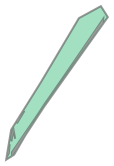

In [189]:
# leftovers = bi
# i=0
print "Intersect before:" , leftovers.intersects(tiles_tmp[i])
print leftovers.area
leftovers = leftovers.difference(tiles_tmp[i])   
print "Intersect after:" ,  leftovers.intersects(tiles_tmp[i])
print leftovers.intersection(tiles_tmp[i]).area
print tiles_tmp[i].area
print leftovers.area
i+=1


leftovers


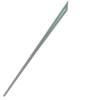

In [126]:
tiles_tmp[i]

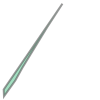

In [120]:
tiles_tmp[i]

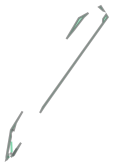

In [118]:
leftovers

In [85]:
len(tiles_tmp)

65

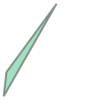

In [46]:
tiles[0]

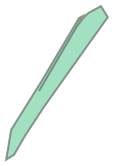

In [48]:
bi.difference(tiles[2])

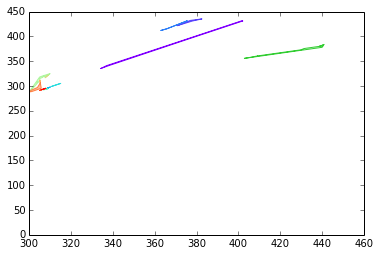

In [29]:
plt.figure()
if  type(leftovers)==shapely.geometry.MultiPolygon:
    visualizeTilesSeparate(leftovers)
else:
    plot_coords(leftovers)
plot_coords(t,color="#32cd32")

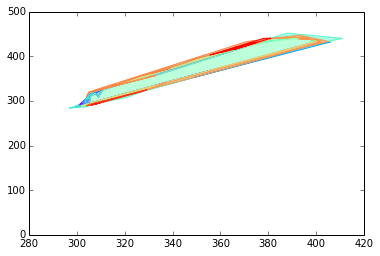

In [321]:
visualizeTilesSeparate(tiles_tmp)

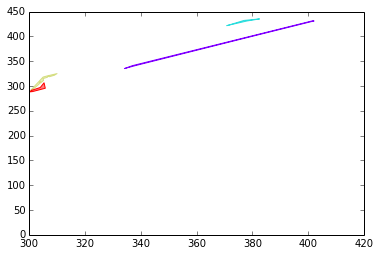

In [319]:
visualizeTilesSeparate(leftovers)

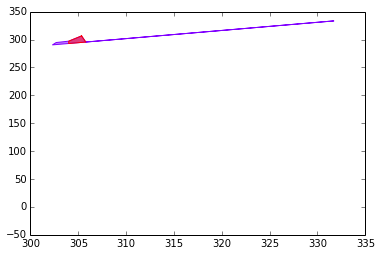

In [314]:
visualizeTilesSeparate([tiles[8],tiles[47]])

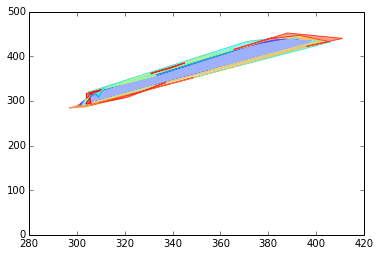

In [311]:
visualizeTilesSeparate(tiles)

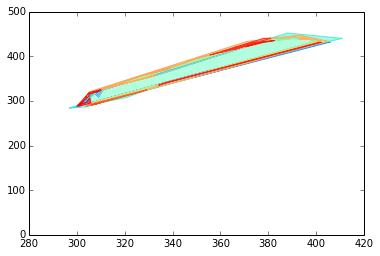

In [309]:
visualizeTilesSeparate(tiles)

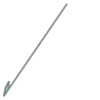

In [306]:
tiles[2]

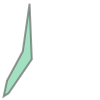

In [305]:
tiles[68]

In [301]:

leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))

ERROR:shapely.geos:TopologyException: side location conflict at 368 418


ValueError: No Shapely geometry can be created from null value